In [79]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [80]:
initial_data = pd.read_csv('./OUTPUT_WBI_exposer_cyclones_v10.csv')

In [81]:
initial_data.head()

,Unnamed: 0,SID,NAME,ISO,YEAR,BASIN,SUB BASIN,NATURE,ISO_TIME,COORDS,...,Rural population (% of total population),Income_level_Final,TOTAL_AFFECTED,in_wbi,pop_max_34,pop_max_50,pop_max_64,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj
0,0,1949163N07145,DELLA,JPN,1949,WP,WP,TS,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","[[35.67, 130.99], [38.35, 135.07], [38.82, 136...",...,36.728,Low,194046,True,16431894.0,7958809.0,4553851.00,1.198300e+07,5.803981e+06,3.320907e+06
1,1,1950241N23140,JANE,JPN,1950,WP,WP,ET,"['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]",...,36.728,Low,642117,True,43343320.0,21380746.0,13972339.00,3.160822e+07,1.559196e+07,1.018936e+07
2,2,1951224N12316,CHARLIE,JAM,1951,NAm,CS,TS,"['1951-08-17 21:00:00', '1951-08-18 12:00:00']","[[17.34, -75.41], [18.3, -79.4]]",...,66.231,Low,20200,True,2753687.5,2750167.0,1948090.75,1.689243e+06,1.687083e+06,1.195052e+06
3,3,1951337N09150,AMY,PHL,1951,WP,WP,TS,"['1951-12-08 18:00:00', '1951-12-08 21:00:00',...","[[11.52, 127.35], [11.34, 127.09], [11.17, 126...",...,69.703,Low_Middle,60000,True,14131997.0,8926450.0,3309632.25,4.760039e+06,3.006670e+06,1.114774e+06
4,4,1952180N05144,EMMA,PHL,1952,WP,WP,TS,"['1952-07-01 18:00:00', '1952-07-01 21:00:00',...","[[9.57, 127.79], [9.63, 127.19], [12.38, 119.4...",...,69.703,Low_Middle,103,True,15232730.0,8281656.5,5903694.00,5.130796e+06,2.789486e+06,1.988524e+06


In [82]:
initial_data['month'] = initial_data['ISO_TIME'].str[7:9] 

In [83]:
initial_data['COORDS_both']=initial_data['COORDS'].str[2:18]
initial_data['COORDS_1'] = initial_data['COORDS_both'].str.split(", ", n = 1, expand = True)[0]
initial_data['COORDS_2'] = initial_data['COORDS_both'].str.split(", ",  expand = True)[1]
initial_data['COORDS_2'] = initial_data['COORDS_2'].str.split("]",  expand = True)[0]
initial_data['COORDS_1'] = initial_data['COORDS_1'].astype(float)
initial_data['COORDS_2'] = initial_data['COORDS_2'].astype(float)

Trying to estimate the Affected population alone, So removing some features

In [84]:
initial_data.columns

Index(['Unnamed: 0', 'SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN',
       'NATURE', 'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS',
       'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
       'STORM_DR_MEAN', 'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP',
       '64KN_ASSETS', '96KN_POP', '96KN_ASSETS', 'CPI', 'TOTAL_DAMAGE_(000$)',
       'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'TOTAL_AFFECTED'

In [85]:
req_columns = ['YEAR','BASIN','SUB BASIN','NATURE','TOTAL_HRS','USA_SSHS','ISO_TIME',
              'WIND_CAL_MIN','WIND_CAL_MAX','WIND_CALC_MEAN','PRES_CAL_MIN','PRES_CAL_MAX',
              'PRES_CALC_MEAN','STORM_SPD_MIN','STORM_SPD_MAX','STORM_SPD_MEAN','STORM_DR_MIN',
              'STORM_SPD_MAX','STORM_DR_MEAN','V_LAND_KN','CPI','TOTAL_DAMAGE_(000$)',
               'Population density (people per sq. km of land area)',
              'Rural population (% of total population)','TOTAL_AFFECTED']
req_columns = ['YEAR','BASIN','SUB BASIN','NATURE','TOTAL_HRS','USA_SSHS','ISO_TIME',
              'WIND_CAL_MIN','WIND_CAL_MAX','WIND_CALC_MEAN','PRES_CAL_MIN','PRES_CAL_MAX',
              'PRES_CALC_MEAN','STORM_SPD_MIN','STORM_SPD_MAX','STORM_SPD_MEAN','STORM_DR_MIN',
              'STORM_SPD_MAX','STORM_DR_MEAN','V_LAND_KN',
               'Population density (people per sq. km of land area)',
              'Rural population (% of total population)','TOTAL_AFFECTED']
req_columns = ['BASIN', 'SUB BASIN', 'COORDS_1', 'COORDS_2', 
       'NATURE', 'ISO_TIME',  'DAY_HRS', 'NIGHT_HRS',
       'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
       'STORM_DR_MEAN', 'V_LAND_KN', 'month', #'CPI',
      # 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 
               #'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 
               #'GDP growth (annual %)',
      # 'GDP per capita (constant 2010 US$)', 
                          #'Net flows from UN agencies US$',
      # 'Life expectancy at birth, total (years)',
       #'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       #'Adjusted savings: education expenditure (% of GNI)',
      # 'Rural population (% of total population)', 
                          'Income_level_Final',
     
       'pop_max_34_adj',
       'pop_max_64_adj', 'TOTAL_AFFECTED']

In [86]:
plt.figure(figsize=(5,5))

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [87]:
corrMatrix=initial_data[ ['BASIN', 'SUB BASIN',
       'NATURE', 'ISO_TIME', 'COORDS',  'DAY_HRS', 'NIGHT_HRS',
       'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
                          'COORDS_1', 'COORDS_2',
       'STORM_DR_MEAN', 'V_LAND_KN', 'month', #'CPI',
      # 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
                          'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 
                          #'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
      # 'Rural population (% of total population)', 
                          'Income_level_Final',
     
       'pop_max_34_adj',
       'pop_max_64_adj', 'TOTAL_AFFECTED']]

(22.5, -0.5)

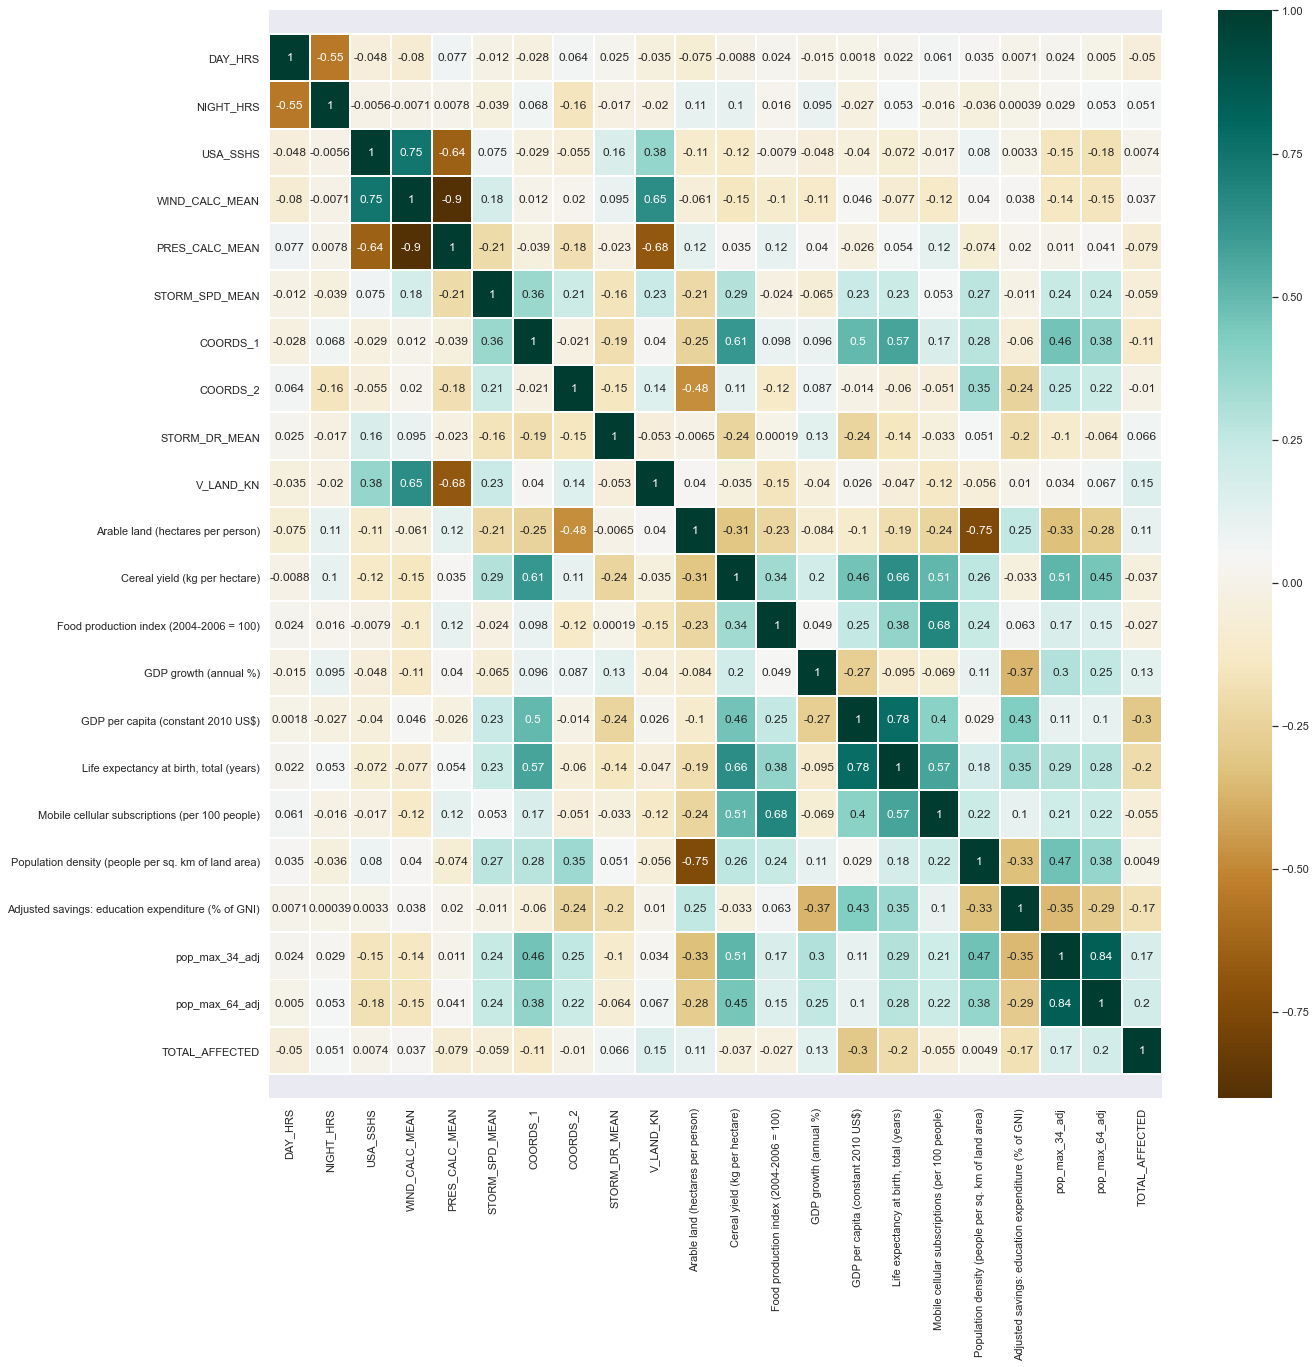

In [88]:
df_num = corrMatrix[corrMatrix.columns.unique()]
corr_num = df_num.corr(method = "spearman")
fig, ax = plt.subplots(figsize=(20,20))
ax = plt.subplot(111)
sns.set(font_scale=1)
sns.heatmap(corr_num, annot=True,  linewidth=1, cmap="BrBG", ax=ax)
bottom, top = ax.get_ylim()             # this fixes a bug where first and last columns were not visualized correctly
ax.set_ylim(bottom + 0.5, top - 0.5)

In [89]:
corrMatrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 29 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   BASIN                                                1005 non-null   object 
 1   SUB BASIN                                            1005 non-null   object 
 2   NATURE                                               1005 non-null   object 
 3   ISO_TIME                                             1005 non-null   object 
 4   COORDS                                               1005 non-null   object 
 5   DAY_HRS                                              1005 non-null   int64  
 6   NIGHT_HRS                                            1005 non-null   int64  
 7   USA_SSHS                                             1005 non-null   int64  
 8   WIND_CALC_MEAN                                       1001 non-null  

In [90]:
data = initial_data[req_columns]
data.head(3)

,BASIN,SUB BASIN,COORDS_1,COORDS_2,NATURE,ISO_TIME,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,...,STORM_DR_MEAN,V_LAND_KN,month,Arable land (hectares per person),Food production index (2004-2006 = 100),Population density (people per sq. km of land area),Income_level_Final,pop_max_34_adj,pop_max_64_adj,TOTAL_AFFECTED
0,WP,WP,35.67,130.99,TS,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...",0,0,0,39.133333,...,91.444444,99.82,06,0.059615,67.79,258.911917,Low,1.198300e+07,3.320907e+06,194046
1,WP,WP,31.71,134.12,ET,"['1950-09-02 18:00:00', '1950-09-03 12:00:00',...",0,6,-1,76.400000,...,37.666667,99.82,09,0.059615,67.79,258.911917,Low,3.160822e+07,1.018936e+07,642117
2,NAm,CS,17.34,-75.41,TS,"['1951-08-17 21:00:00', '1951-08-18 12:00:00']",0,15,1,88.500000,...,283.500000,132.40,08,0.100541,69.93,152.453647,Low,1.689243e+06,1.195052e+06,20200


Extract Month as the cyclone can have seasonal preference

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 22 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   BASIN                                                1005 non-null   object 
 1   SUB BASIN                                            1005 non-null   object 
 2   COORDS_1                                             1005 non-null   float64
 3   COORDS_2                                             1005 non-null   float64
 4   NATURE                                               1005 non-null   object 
 5   ISO_TIME                                             1005 non-null   object 
 6   DAY_HRS                                              1005 non-null   int64  
 7   NIGHT_HRS                                            1005 non-null   int64  
 8   USA_SSHS                                             1005 non-null  

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 22 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   BASIN                                                1005 non-null   object 
 1   SUB BASIN                                            1005 non-null   object 
 2   COORDS_1                                             1005 non-null   float64
 3   COORDS_2                                             1005 non-null   float64
 4   NATURE                                               1005 non-null   object 
 5   ISO_TIME                                             1005 non-null   object 
 6   DAY_HRS                                              1005 non-null   int64  
 7   NIGHT_HRS                                            1005 non-null   int64  
 8   USA_SSHS                                             1005 non-null  

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 22 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   BASIN                                                1005 non-null   object 
 1   SUB BASIN                                            1005 non-null   object 
 2   COORDS_1                                             1005 non-null   float64
 3   COORDS_2                                             1005 non-null   float64
 4   NATURE                                               1005 non-null   object 
 5   ISO_TIME                                             1005 non-null   object 
 6   DAY_HRS                                              1005 non-null   int64  
 7   NIGHT_HRS                                            1005 non-null   int64  
 8   USA_SSHS                                             1005 non-null  

In [94]:
data['MONTH'] = data['ISO_TIME'].apply(lambda x: [int(i[5:7]) for i in eval(x)][0])
data.drop('ISO_TIME', axis=1, inplace=True)

<ipython-input-94-055e428e1f7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['ISO_TIME'].apply(lambda x: [int(i[5:7]) for i in eval(x)][0])
/Users/anurkayeva/anaconda3/envs/elev/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [95]:
data.head(3)

,BASIN,SUB BASIN,COORDS_1,COORDS_2,NATURE,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,...,V_LAND_KN,month,Arable land (hectares per person),Food production index (2004-2006 = 100),Population density (people per sq. km of land area),Income_level_Final,pop_max_34_adj,pop_max_64_adj,TOTAL_AFFECTED,MONTH
0,WP,WP,35.67,130.99,TS,0,0,0,39.133333,1000.333333,...,99.82,06,0.059615,67.79,258.911917,Low,1.198300e+07,3.320907e+06,194046,6
1,WP,WP,31.71,134.12,ET,0,6,-1,76.400000,974.833333,...,99.82,09,0.059615,67.79,258.911917,Low,3.160822e+07,1.018936e+07,642117,9
2,NAm,CS,17.34,-75.41,TS,0,15,1,88.500000,974.500000,...,132.40,08,0.100541,69.93,152.453647,Low,1.689243e+06,1.195052e+06,20200,8


In [96]:
data['USA_SSHS'] = data['USA_SSHS'].replace(-5, np.nan)

<ipython-input-96-dee113c4135b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['USA_SSHS'] = data['USA_SSHS'].replace(-5, np.nan)


In [97]:
data.pivot_table(values='TOTAL_AFFECTED', index='BASIN')

,TOTAL_AFFECTED
BASIN,
EP,6.200989e+04
NAm,2.915376e+05
NI,1.702525e+06
SI,1.712153e+05
SP,4.268587e+04
WP,7.791611e+05


In [98]:
data.pivot_table(values='TOTAL_AFFECTED', index='SUB BASIN')

,TOTAL_AFFECTED
SUB BASIN,
AS,5.934567e+04
BB,2.432826e+06
CP,1.408350e+04
CS,2.451549e+05
EA,1.986558e+04
EP,6.188004e+04
GM,4.162959e+05
NAm,1.911837e+05
SI,1.963969e+05


In [99]:
data.pivot_table(values='TOTAL_AFFECTED', index='NATURE')

,TOTAL_AFFECTED
NATURE,
DS,47498.125000
ET,271279.315789
MX,542738.500000
NR,673563.627451
SS,57508.250000
TS,584955.549618


In [100]:
## NATURE seems to be ordinal so encoding
from sklearn.preprocessing import LabelEncoder
oe = LabelEncoder()
oe.fit(data['NATURE'])
data['NATURE'] = oe.transform(data['NATURE'])

<ipython-input-100-3653da64c0f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NATURE'] = oe.transform(data['NATURE'])


In [101]:
# One Hot encoding for the rest of the categorical variables
data = pd.concat([pd.get_dummies(data[['month', 'Income_level_Final', 'SUB BASIN']]), data],axis=1)
data.drop(columns=['month','Income_level_Final',  'SUB BASIN'],axis=1,inplace=True)

In [102]:
data.head(3)

,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,...,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,Arable land (hectares per person),Food production index (2004-2006 = 100),Population density (people per sq. km of land area),pop_max_34_adj,pop_max_64_adj,TOTAL_AFFECTED,MONTH
0,0,0,0,0,0,1,0,0,0,0,...,19.0,91.444444,99.82,0.059615,67.79,258.911917,1.198300e+07,3.320907e+06,194046,6
1,0,0,0,0,0,0,0,0,1,0,...,23.0,37.666667,99.82,0.059615,67.79,258.911917,3.160822e+07,1.018936e+07,642117,9
2,0,0,0,0,0,0,0,1,0,0,...,15.5,283.500000,132.40,0.100541,69.93,152.453647,1.689243e+06,1.195052e+06,20200,8


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 47 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   month_01                                             1005 non-null   uint8  
 1   month_02                                             1005 non-null   uint8  
 2   month_03                                             1005 non-null   uint8  
 3   month_04                                             1005 non-null   uint8  
 4   month_05                                             1005 non-null   uint8  
 5   month_06                                             1005 non-null   uint8  
 6   month_07                                             1005 non-null   uint8  
 7   month_08                                             1005 non-null   uint8  
 8   month_09                                             1005 non-null  

In [104]:
data.describe()

,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,...,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,Arable land (hectares per person),Food production index (2004-2006 = 100),Population density (people per sq. km of land area),pop_max_34_adj,pop_max_64_adj,TOTAL_AFFECTED,MONTH
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,...,1005.000000,1005.000000,1005.000000,1004.000000,1001.000000,1005.000000,9.250000e+02,9.250000e+02,1.005000e+03,1005.000000
mean,0.051741,0.028856,0.034826,0.024876,0.040796,0.047761,0.108458,0.173134,0.223881,0.144279,...,12.047601,215.481903,90.011543,0.187221,95.834758,324.147607,2.881670e+07,6.236887e+06,5.768923e+05,7.780100
std,0.221615,0.167484,0.183430,0.155824,0.197916,0.213367,0.311112,0.378552,0.417051,0.351547,...,6.586180,96.090666,31.633313,0.352292,29.889039,1016.048534,4.467633e+07,1.195170e+07,1.991082e+06,2.762945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.565217,2.000000,30.000000,0.000425,17.390000,1.786314,0.000000e+00,0.000000e+00,2.000000e+00,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.666667,153.800000,62.400000,0.058654,76.520000,50.188247,3.102442e+06,2.871373e+05,3.000000e+03,7.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.666667,260.750000,89.200000,0.090486,99.320000,144.583453,1.115819e+07,1.615052e+06,3.000000e+04,8.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.411765,288.250000,114.700000,0.191018,115.290000,301.992208,3.472225e+07,6.091829e+06,2.480580e+05,10.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,49.800000,358.000000,171.800000,3.069373,223.020000,20479.769990,3.764972e+08,1.073686e+08,2.962200e+07,12.000000


In [105]:
#data['YEAR'] = 2020 - data['YEAR']

In [106]:
data.shape

(1005, 47)

In [107]:
data=data.dropna()

In [108]:
data = data.drop('BASIN', axis=1)

In [109]:
# ??? Perform min_max_scaler to YEAR, TOTAL_HRS,MONTH
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [110]:
y = data['TOTAL_AFFECTED']
X = data.drop('TOTAL_AFFECTED',axis=1)

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [112]:
clf =  SVR(

C=10, cache_size=200, coef0=0.01, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False

)
clf.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.01, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [113]:

rmse = math.sqrt(mean_absolute_error(y_pred, y_test))
rmse

3040.3582685172814

In [114]:

r2_score(y_pred, y_test)

-27.964849397555003

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [116]:


pipeline = Pipeline([('scaler', StandardScaler()), ( 'mm',MinMaxScaler()),
                     ('estimator', SVR(

    C=10, cache_size=200, coef0=0.01, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False

))])

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_mm = MinMaxScaler()
y_train = y_mm.fit_transform(y_train)
pipeline.fit(X_train, y_train)
y_pred= pipeline.predict(X_test)


#inverse
y_pred = y_scaler.inverse_transform(y_pred)
type(y_pred)
y_pred = y_mm.inverse_transform(y_pred.reshape(-1, 1))

/Users/anurkayeva/anaconda3/envs/elev/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [117]:

mean_absolute_error(y_pred, y_test)

8915300.952226385

In [118]:
import math
rmse = math.sqrt(mean_absolute_error(y_pred, y_test))
rmse

2985.850122197426

In [119]:

r2_score(y_pred, y_test)

-37.73118805567246

In [462]:
data.describe()

,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,...,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,Arable land (hectares per person),Food production index (2004-2006 = 100),Population density (people per sq. km of land area),pop_max_34_adj,pop_max_64_adj,TOTAL_AFFECTED,MONTH
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,...,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,9.170000e+02,9.170000e+02,9.170000e+02,917.000000
mean,0.035987,0.029444,0.035987,0.025082,0.044711,0.051254,0.109051,0.179935,0.232279,0.148310,...,12.246098,216.340620,89.845192,0.180490,96.125494,311.617124,2.902644e+07,6.283495e+06,6.240227e+05,7.824427
std,0.186359,0.169139,0.186359,0.156459,0.206781,0.220636,0.311874,0.384343,0.422517,0.355601,...,6.662189,97.006383,31.708318,0.324295,30.411013,821.286664,4.481217e+07,1.199283e+07,2.077623e+06,2.607248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.565217,2.000000,30.000000,0.000425,17.390000,1.868972,0.000000e+00,0.000000e+00,2.000000e+00,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.771429,154.608696,62.200000,0.059169,76.450000,52.384693,3.214771e+06,2.890673e+05,3.500000e+03,7.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.826087,264.000000,89.090000,0.090486,99.760000,145.317352,1.130992e+07,1.639721e+06,3.000000e+04,8.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.500000,288.333333,114.400000,0.191018,115.890000,298.890818,3.484564e+07,6.223113e+06,2.740000e+05,10.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,49.800000,358.000000,171.800000,2.961276,223.020000,7039.714286,3.764972e+08,1.073686e+08,2.962200e+07,12.000000
